In [7]:
from datasets import load_dataset

imagenette = load_dataset(
    'frgfm/imagenette',
    'full_size',
    split='train',
    trust_remote_code=True
)
imagenette

0000.parquet:   0%|          | 0.00/506M [00:00<?, ?B/s]

0001.parquet:   0%|          | 0.00/509M [00:00<?, ?B/s]

0002.parquet:   0%|          | 0.00/87.0M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

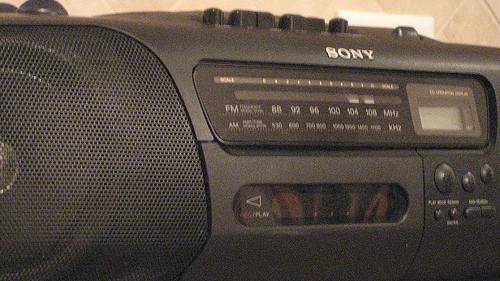

In [8]:
imagenette[0]['image']

In [ ]:
# Imports CLIP libraries
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch

# Sets computation device to whatever is available (likely CPU in this case)
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")

# Specifices version of CLIP to be used from huggingface 
model_id = "openAI/clip-vit-base-patch32"

# Loads the model, tokenizer, and processor
model = CLIPModel.from_pretrained(model_id).to(device)
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

C:\Users\SEANM\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\SEANM\.cache\huggingface\hub\models--openAI--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [117]:
# Sets input prompt and tokenizes it using tokenizer
prompt = "A dog in the snow"

inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[49406,   320,  1929,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
# Embeds the prompt into a vector space in shape suitable for the model
text_emb = model.get_text_features(**inputs)
text_emb.shape

torch.Size([1, 512])

In [119]:
# Processor is used for image and text processing, however this instance is only for images and returns it as a tensor.
image = processor(
    text=None,
    images=imagenette[0]['image'],
    return_tensors="pt"
)['pixel_values'].to(device)
image.shape

torch.Size([1, 3, 224, 224])

In [120]:
image.squeeze(0).T.shape


torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.0298605].


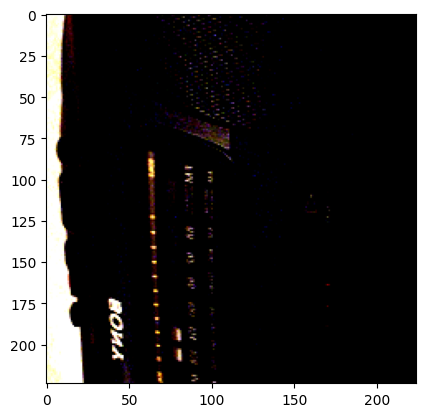

In [121]:
# Displays processed image 
import matplotlib.pyplot as plt

plt.imshow(image.squeeze(0).T)

In [122]:
# Embeds image into vector space, similar to text embedding 
image_emb = model.get_image_features(image)
image_emb.shape

torch.Size([1, 512])

In [123]:
import numpy as np 

# The following code selects a random set of 100 images from imagenette for testing
np.random.seed(0)
sample_idx = np.random.randint(0, len(imagenette)+1, 100).tolist()
images = [imagenette[i]['image'] for i in sample_idx]
len(images)

100

In [124]:
from tqdm.auto import tqdm

batch_size = 16
image_arr = None

for i in tqdm(range(0, len(images), batch_size)):
    # select batch of images
    batch = images[i:i+batch_size]
    # process and resize
    batch = processor(
        text=None,
        images=batch,
        return_tensors='pt',
        padding=True
    )['pixel_values'].to(device)
    # get image embeddings
    batch_emb = model.get_image_features(pixel_values=batch)
    #conver to numpy array
    batch_emb = batch_emb.squeeze(0)
    batch_emb = batch_emb.cpu().detach().numpy()
    #add to larger array of all image embeddings
    if image_arr is None:
        image_arr = batch_emb
    else:
        image_arr = np.concatenate((image_arr, batch_emb), axis=0)
image_arr.shape


  0%|          | 0/7 [00:00<?, ?it/s]

(100, 512)

In [125]:
image_arr.min(), image_arr.max() 

(np.float32(-7.994913), np.float32(3.152507))

In [126]:
# Normalizes the image embeddings
image_arr = image_arr.T / np.linalg.norm(image_arr, axis=1)

In [127]:
image_arr = image_arr.T
image_arr.shape
image_arr.min(), image_arr.max()

(np.float32(-0.69967145), np.float32(0.31254968))

In [128]:
text_emb = text_emb.cpu().detach().numpy()

In [129]:
# Takes the dot product of each image and the prompt to determine similarities scores
scores = np.dot(text_emb, image_arr.T)
scores.shape

(1, 100)

In [130]:
# Takes the top 5 image scores and stores them in an index array
top_k = 5
idx = np.argsort(-scores[0])[:top_k]
idx

array([71, 24, 86, 76, 85])

2.4251525


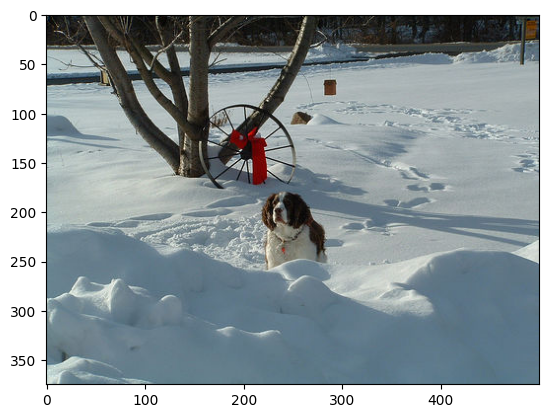

2.219563


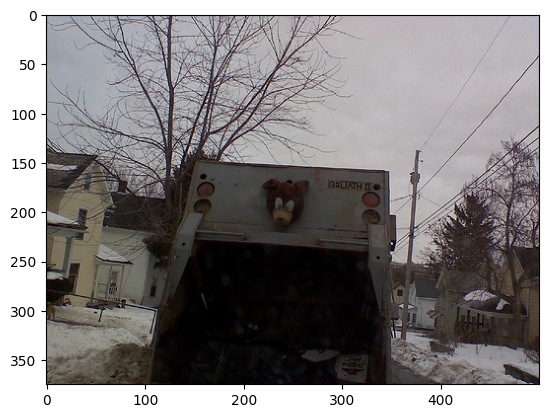

1.8729135


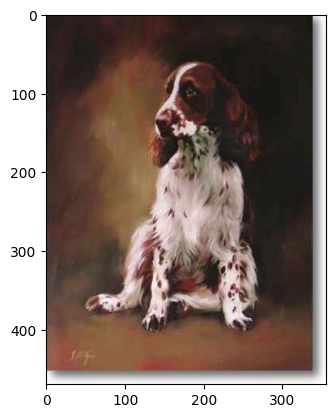

1.768663


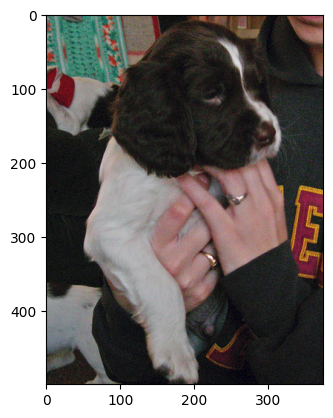

1.7330449


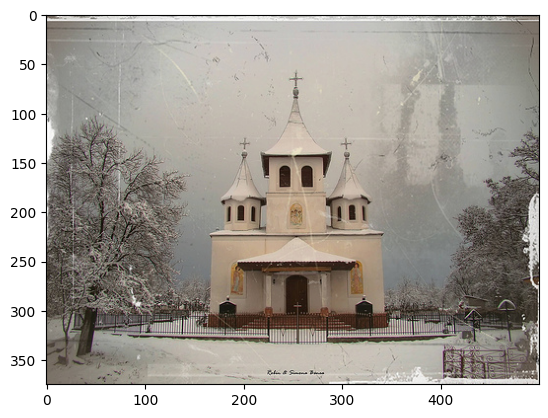

In [131]:
# Prints the 5 images with the highest scores
for i in idx:
    print(scores[0][i])
    plt.imshow(images[i])
    plt.show()